In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%%capture

!pip install langchain "unstructured[all-docs]" unstructured-inference pydantic lxml
!pip install --upgrade nltk
!pip uninstall pdfminer.six --y
!pip install pikepdf pypdf wrapt pdfminer.six
!pip install unstructured_pytesseract
# !brew install poppler-utils
# !brew install tesseract-ocr
# !brew install poppler-qt5
# !brew install tesseract-lang
# !brew install tesseract

!sudo apt-get install poppler-utils
!sudo apt install tesseract-ocr

!pip install pillow pydantic lxml pillow matplotlib chromadb tiktoken
!pip install -U langchain openai langchain-chroma langchain-experimental
!pip install lamini
!pip install -U langchain_ollama
!pip install -qU langchain-openai

In [ ]:
import os
from typing import Any

from pydantic import BaseModel
from unstructured.partition.pdf import partition_pdf
from langchain_text_splitters import CharacterTextSplitter

In [ ]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

from unstructured.partition.pdf import partition_pdf
from langchain_text_splitters import CharacterTextSplitter
def extract_pdf_elements(images_path, file_name):
  return partition_pdf(
      filename=file_name,
      extract_images_in_pdf=True,
      strategy="hi_res",
      infer_table_structure=True,
      extract_image_block_output_dir=images_path
  )


def categorize_elements(raw_pdf_elements):
  tables = []
  texts = []

  for element in raw_pdf_elements:
    if "unstructured.documents.elements.Table" in str(type(element)):
      tables.append(str(element))
    elif "unstructured.documents.elements.ListItem" in str(type(element)) or "unstructured.documents.elements.NarrativeText" in str(type(element)):
      texts.append(str(element))

  return tables, texts

images_path = "/content/drive/MyDrive/rag/images"
file_name = "/content/drive/MyDrive/rag/13-24.pdf"

raw_pdf_elements = extract_pdf_elements(images_path, file_name)
tables, texts = categorize_elements(raw_pdf_elements)

text_splitter = CharacterTextSplitter.from_tiktoken_encoder(
  chunk_size=4000,
  chunk_overlap=0,
)
joined_texts = " ".join(texts)
texts_4k_token = text_splitter.split_text(joined_texts)

config.json:   0%|          | 0.00/1.47k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/115M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/table-transformer-structure-recognition were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# saving retrieved texts and tables to a file

with open("/content/drive/MyDrive/rag/13-24_text.txt", "w") as f:
  f.write('\n'.join(texts_4k_token))

with open("/content/drive/MyDrive/rag/13-24_table.txt", "w") as f:
  f.write('\n'.join(tables))

In [3]:
#loading saved texts and tables from file
texts = []
with open("/content/drive/MyDrive/rag/13-24_text.txt", "r") as f:
  for line in f:
    texts.append(line)

tables = []
with open("/content/drive/MyDrive/rag/13-24_table.txt", "r") as f:
  for line in f:
    tables.append(line)

In [ ]:
element_dict = [el.to_dict() for el in raw_pdf_elements]

unique_types = set()
for item in element_dict:
  unique_types.add(item['type'])

print(unique_types)

{'UncategorizedText', 'ListItem', 'FigureCaption', 'Table', 'Title', 'Footer', 'Header', 'NarrativeText', 'Image'}


In [ ]:
# from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

import os
import lamini
from lamini import Lamini
from dotenv import load_dotenv

In [11]:
import os
import time
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
import load_dotenv

load_dotenv()
OPENAI_API_KEY = os.environ["OPENAI_API_KEY"]

def generate_text_summaries(texts, tables, summarize_texts=False):

    prompt_text = """You are an assistant tasked with summarizing tables and text for retrieval. \
    These summaries will be embedded and used to retrieve the raw text or table elements. \
    Give a concise summary of the table or text that is well optimized for retrieval. Table or text: {element} """

    prompt = ChatPromptTemplate.from_template(prompt_text)

    model = ChatOpenAI(model="gpt-4o-mini", temperature=0)
    summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()

    text_summaries = []
    table_summaries = []

    if texts and summarize_texts:
      text_summaries = summarize_chain.batch(texts, {"max_concurrency": 5})
    elif texts:
        text_summaries = texts

    if tables:
      time.sleep(60)
      table_summaries = summarize_chain.batch(tables, {"max_concurrency": 5})

    return text_summaries, table_summaries

text_summaries, table_summaries = generate_text_summaries(texts=texts, tables=tables, summarize_texts=True)

In [13]:
print(text_summaries)

['### Summary of Key Concepts in Cardiovascular and Pulmonary Disorders\n\n#### General Principles\n- **Cholesterol and Lipoproteins**: Cholesterol is essential for life, involved in bile acids, cell membranes, and hormones. Atherosclerosis risk increases with serum cholesterol levels. Major lipoproteins include VLDL (15-20% of TC), LDL (60-70% of TC, primary atherosclerosis contributor), and HDL (transports cholesterol to the liver).\n- **Dyslipidemia Management**: The 2013 ACC/AHA guidelines focus on patient characteristics and ASCVD risk rather than specific LDL-C targets. Statins are the first-line treatment for lowering cholesterol and reducing CHD risk.\n\n#### Patient Assessment\n- **Dyslipidemia Evaluation**: Assess for secondary causes (e.g., diabetes, hypothyroidism), presence of CHD, and risk factors. Diagnosis involves lipoprotein profiling and family history.\n- **Hypertension**: Affects 30% of adults, with higher prevalence in blacks. Diagnosis requires multiple BP measur

In [16]:
import base64
from io import BytesIO

from IPython.display import HTML, display_html
from PIL import Image

from langchain_core.messages import HumanMessage
# from langchain_ollama import ChatOllama
from langchain_community.llms import Ollama

def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        encoded_string = base64.b64encode(image_file.read()).decode("utf-8")
    return encoded_string


def image_summarize(img_base64, prompt):

    chat = ChatOpenAI(model="gpt-4o-mini", max_tokens=1024)

    msg = chat.invoke(
        [
            HumanMessage(
                content=[
                    {"type": "text", "text": prompt},
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/jpeg;base64, {img_base64}"
                            },
                    }
                ]
            )
        ]
    )

    return msg.content

def generate_img_summaries(path):
    img_base64_list = []

    image_summaries = []

    prompt = """"You are an assistant tasked with summarizing these images for retrieval. \
                These summaries will be embedded and used to retrieve the raw image. \
                Give a concise summary of the image that is well optimized for retrieval."""

    for img_file in sorted(os.listdir(path)):
        if img_file.endswith(".jpg"):
            img_path = os.path.join(path, img_file)
            img_base64 = encode_image(img_path)
            img_base64_list.append(img_base64)

            image_summaries.append(image_summarize(img_base64, prompt))

    return img_base64_list, image_summaries

# Image summaries
images_path = "/content/drive/MyDrive/rag/images"
img_base64_list, image_summaries = generate_img_summaries(images_path)

In [19]:
print(image_summaries)

['Summary: Title page for Chapter 13, Section II, focusing on "Cardiac and Vascular Disorders," featuring a textured blue background.', 'Diagram illustrating Korotkoff sounds associated with blood pressure measurement. It displays pressure values: 124 mm Hg (systolic), 112 mm Hg, 98 mm Hg, 86 mm Hg, and 82 mm Hg (diastolic). The sounds are represented visually along a vertical scale.', 'Image summary: A blue hexagonal shape with the word "Trigger" prominently displayed in bold black text.', 'Flowchart illustrating the systemic activation of the clotting cascade, detailing the roles of thrombin and plasmin. Thrombin triggers platelet aggregation and microvascular fibrin deposition, while plasmin is involved in clotting factor degradation and fibrin degradation, leading to hemorrhage and microvascular complications. Key terms include thrombocytopenia, platelet dysfunction, and formation of fibrin degradation products.', 'Diagram highlighting "Systemic circulating Thrombin" in a biologica

In [21]:
import uuid

from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.storage import InMemoryStore
from langchain_chroma import Chroma
from langchain_core.documents import Document
from langchain_openai import OpenAIEmbeddings
# from langchain_ollama import OllamaEmbeddings


def create_multi_vector_retriever(vectorstore, text_summaries, texts, table_summaries, tables, image_summaries, img_base64_list):

  store = InMemoryStore()
  id_key = "doc_id"

  retriever = MultiVectorRetriever(
      vectorstore=vectorstore,
      docstore=store,
      id_key=id_key
  )

  def add_documents(retriever, doc_summaries, doc_contents):
    doc_ids = [str(uuid.uuid4()) for _ in doc_contents]
    summary_docs = [
        Document(page_content=s, metadata={id_key: doc_ids[i]})
        for i, s in enumerate(doc_summaries)
    ]
    retriever.vectorstore.add_documents(summary_docs)
    retriever.docstore.mset(list(zip(doc_ids, doc_contents)))

  if text_summaries:
    add_documents(retriever, text_summaries, texts)
  if table_summaries:
    add_documents(retriever, table_summaries, tables)
  if image_summaries:
    add_documents(retriever, image_summaries, img_base64_list)

  return retriever


vectorstore = Chroma(
    collection_name="rag",
    embedding_function=OpenAIEmbeddings(),
    persist_directory="/content/drive/MyDrive/rag/db"
)

multi_vector_retriever = create_multi_vector_retriever(
    vectorstore,
    text_summaries,
    texts,
    table_summaries,
    tables,
    image_summaries,
    img_base64_list)


In [54]:
import io
import re

from IPython.display import HTML, display
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from PIL import Image

def plt_imge_base64(img_base64):
  image_html = f'<img src="data:image/jpeg;base64,{img_base64}" />'
  display(HTML(image_html))

def looks_like_base64(sb):
  return re.match("^[A-Za-z0-9+/]+[=]{0,2}$", sb) is not None

def is_image_data(b64data):
  image_signatures = {
      b"\xff\xd8\xff": "jpg",
      b"\x89\x50\x4e\x47\x0d\x0a\x1a\x0a": "png",
      b"\x47\x49\x46\x38": "gif",
      b"\x52\x49\x46\x46": "webp",
  }
  try:
    header = base64.b64decode(b64data)[:8]
    for sig, format in image_signatures.items():
      if header.startswith(sig):
        return True
    return False
  except Exception:
    return False

def resize_base64_image(base64_string, size=(128, 128)):
  img_data = base64.b64decode(base64_string)
  img = Image.open(io.BytesIO(img_data))

  resized_img = img.resize(size, Image.LANCZOS)
  buffered = io.BytesIO()
  resized_img.save(buffered, format=img.format)

  return base64.b64encode(buffered.getvalue()).decode("utf-8")

def split_image_text_types(docs):
    """
    Split base64-encoded images and texts
    """
    b64_images = []
    texts = []
    for doc in docs:
        # Check if the document is of type Document and extract page_content if so
        if isinstance(doc, Document):
            doc = doc.page_content
        if looks_like_base64(doc) and is_image_data(doc):
            try: # Try to resize the image, if it fails, skip it
                doc = resize_base64_image(doc, size=(1300, 600))
                b64_images.append(doc)
            except Exception as e:
                pass
        else:
            texts.append(doc)
    return {"images": b64_images, "texts": texts}


def img_prompt_func(data_dict):
    """
    Join the context into a single string
    """
    formatted_texts = "\n".join(data_dict["context"]["texts"])
    messages = []

    # Adding image(s) to the messages if present
    if data_dict["context"]["images"]:
        for image in data_dict["context"]["images"]:
            image_message = {
                "type": "image_url",
                "image_url": {"url": f"data:image/jpeg;base64,{image}"},
            }
            messages.append(image_message)

    # Adding the text for analysis
    text_message = {
        "type": "text",
        "text": (
            "You are medical doctor tasked with providing clinical decisions.\n"
            "You will be given a mix of text, tables, and image(s) usually of graphs, inforgraphics, x-rays, CT scans and MRIs.\n"
            "Use this information to provide clinical information related to the user question. \n"
            f"User-provided question: {data_dict['question']}\n\n"
            "Text and / or tables:\n"
            f"{formatted_texts}"
        ),
    }
    messages.append(text_message)
    return [HumanMessage(content=messages)]


def multi_modal_rag_chain(retriever):
    """
    Multi-modal RAG chain
    """

    # Multi-modal LLM
    model = ChatOpenAI(temperature=0, model="gpt-4o-mini", max_tokens=1024)

    # RAG pipeline
    chain = (
        {
            "context": retriever | RunnableLambda(split_image_text_types),
            "question": RunnablePassthrough(),
        }
        | RunnableLambda(img_prompt_func)
        | model
        | StrOutputParser()
    )

    return chain


# Create RAG chain
chain_multimodal_rag = multi_modal_rag_chain(multi_vector_retriever)

###### Testing the retriever


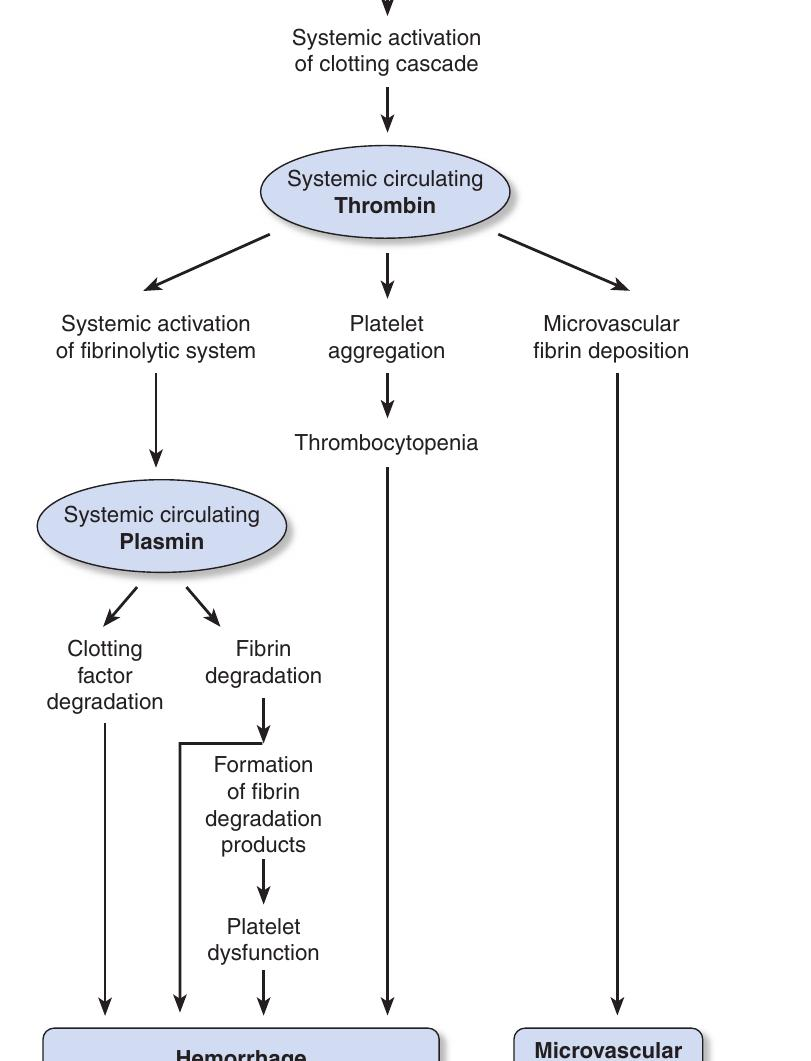

In [66]:
query = "What triggers platelet aggregation"
result = multi_vector_retriever.invoke(query)
plt_imge_base64(result[0])

###### testing rag

In [55]:
query = "Tell me about atherosclerosis"
print(chain_multimodal_rag.invoke(query))

### Overview of Atherosclerosis

Atherosclerosis is a chronic inflammatory disease characterized by the buildup of plaques within the arterial walls, leading to narrowing and hardening of the arteries. This condition is a major contributor to cardiovascular diseases, including coronary artery disease (CAD), myocardial infarction (heart attack), and stroke.

#### Pathophysiology
- **Cholesterol and Lipoproteins**: Cholesterol is essential for various bodily functions, but elevated levels, particularly low-density lipoprotein cholesterol (LDL-C), are directly linked to an increased risk of atherosclerosis. LDL-C is the primary contributor to plaque formation, while high-density lipoprotein cholesterol (HDL-C) helps transport cholesterol from peripheral tissues back to the liver, which is considered protective against atherosclerosis.
- **Plaque Formation**: Atherosclerosis begins with endothelial injury, which can be caused by factors such as hypertension, smoking, diabetes, and high cho

In [56]:
!git clone https://github.com/onyekaokonji/LLaVA-Med.git LLaVA_Med

Cloning into 'LLaVA_Med'...
remote: Enumerating objects: 389, done.
remote: Counting objects: 100% (83/83), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 389 (delta 32), reused 70 (delta 30), pack-reused 306 (from 1)
Receiving objects: 100% (389/389), 77.07 MiB | 14.76 MiB/s, done.
Resolving deltas: 100% (104/104), done.


In [57]:
import warnings
warnings.filterwarnings('ignore')

import os
os.chdir("/content/LLaVA_Med")

In [58]:
%%capture
!pip install -q -e .

In [59]:
from llava.model.builder import load_pretrained_model
from llava.mm_utils import get_model_name_from_path

model_path_2 = "microsoft/llava-med-v1.5-mistral-7b"

tokennizer, model, image_processor, context_len = load_pretrained_model(
    model_path=model_path_2,
    # model_base=model_base,
    model_base=None,
    # model_name=get_model_name_from_path(model_name),
    model_name=get_model_name_from_path(model_path_2)
)

tokenizer_config.json:   0%|          | 0.00/1.46k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/438 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.41k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/73.2k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.93G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/262M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.76k [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some weights of the model checkpoint at microsoft/llava-med-v1.5-mistral-7b were not used when initializing LlavaMistralForCausalLM: ['model.vision_tower.vision_tower.vision_model.encoder.layers.16.self_attn.k_proj.weight', 'model.vision_tower.vision_tower.vision_model.encoder.layers.4.self_attn.k_proj.bias', 'model.vision_tower.vision_tower.vision_model.encoder.layers.22.layer_norm1.bias', 'model.vision_tower.vision_tower.vision_model.encoder.layers.14.layer_norm2.weight', 'model.vision_tower.vision_tower.vision_model.encoder.layers.0.mlp.fc2.weight', 'model.vision_tower.vision_tower.vision_model.encoder.layers.8.mlp.fc2.bias', 'model.vision_tower.vision_tower.vision_model.encoder.layers.7.self_attn.v_proj.weight', 'model.vision_tower.vision_tower.vision_model.encoder.layers.18.self_attn.q_proj.bias', 'model.vision_tower.vision_tower.vision_model.encoder.layers.19.mlp.fc2.weight', 'model.vision_tower.vision_tower.vision_model.encoder.layers.7.layer_norm1.weight', 'model.vision_tower.v

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

In [3]:
%%capture
!pip install --force-reinstall pydantic
%pip install gradio

In [5]:
import gradio as gr
import io
from contextlib import redirect_stdout

from llava.eval.run_llava import eval_model

with gr.Blocks(theme=gr.themes.Glass()) as app:
    with gr.Column(scale=1):
        gr.Markdown("<center><h1>LLaVa-Med + RAG</h1></center>")

        with gr.Row():
            image = gr.Image(type="filepath", scale=2)
            question = gr.Textbox(placeholder="Enter a question", scale=3)

        with gr.Row():
            answer = gr.Textbox(placeholder="Answer pops up here", scale=1)

        def run_inference(image, question):
            context = chain_multimodal_rag.invoke(question)
            enhanced_query = f"Question: {question}\n\nAdditional Context: {context}\n\nPlease analyze the image and answer the question based on the given context."
            args = type('Args', (), {
                "model_path": model_path_2,
                "model_base": None,
                "image_file": image,
                "query": enhanced_query,
                "conv_mode": None,
                "sep": ",",
                "temperature": 0,
                "top_p": None,
                "num_beams": 1,
                "max_new_tokens": 512
                })()

            # Capture the printed output of eval_model
            f = io.StringIO()
            with redirect_stdout(f):
                eval_model(args)
            output = f.getvalue()

            return output

        with gr.Row():
            btn = gr.Button("Run Inference", scale=1)

        btn.click(fn=run_inference, inputs=[image, question], outputs=answer)

app.launch(share=True, debug=True, height=800, width="100%")

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://694a6b8730274b8455.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://694a6b8730274b8455.gradio.live
